In [20]:
import os, re, random, time
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from PIL import Image
from transformers import DistilBertModel, DistilBertTokenizer
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing

## Creating a class for extracting the image and text

In [21]:
#############################################
# Multi-modal dataset
#############################################

class MultiModalDataset(datasets.ImageFolder):
    """
    A custom dataset that extends ImageFolder to also extract text from the image file name.a
    Each sample is returned as a dictionary with keys:
      - 'image': the transformed image tensor,
      - 'text': a string extracted from the file name,
      - 'label': the class label.
    """
    def __getitem__(self, index):
        # Get image path and label from the parent ImageFolder class
        path, label = self.samples[index]
        image = self.loader(path)
        if self.transform is not None:
            image = self.transform(image)
        # Extract text from file name (remove extension, replace underscores, remove digits)
        filename = os.path.basename(path)
        filename_no_ext, _ = os.path.splitext(filename)
        text = filename_no_ext.replace('_', ' ')
        text = re.sub(r'\d+', '', text)  # remove digits
        return {"image": image, "text": text, "label": label}

## Finding the directories Train, Val and Test

In [22]:
#############################################
# Directories 
#############################################


base_dir = '/work/TALC/enel645_2025w/garbage_data/'

if not os.path.exists(base_dir):
    base_dir = "/home/n-iznat/Desktop/garbage_data"

if not os.path.exists(base_dir):
    raise FileNotFoundError(f"dataset folder not found at: {base_dir}")
else:
    print("dataset folder exists:", base_dir)

# List folders in the dataset directory
drive_folders = os.listdir(base_dir)
print("Folders in dataset directory:", drive_folders)

# Define data directories
TRAIN_DIR = os.path.join(base_dir, "CVPR_2024_dataset_Train")
VAL_DIR   = os.path.join(base_dir, "CVPR_2024_dataset_Val")
TEST_DIR  = os.path.join(base_dir, "CVPR_2024_dataset_Test")

# If validation or test directories are missing, use TRAIN as a fallback.
for dir_name, dir_path in zip(["Train", "Val", "Test"], [TRAIN_DIR, VAL_DIR, TEST_DIR]):
    if not os.path.exists(dir_path):
        print(f"WARNING: {dir_name} directory not found at: {dir_path}")
        if dir_name in ["Val", "Test"]:
            print(f"Using TRAIN directory for {dir_name} to avoid errors.")
            if dir_name == "Val":
                VAL_DIR = TRAIN_DIR
            else:
                TEST_DIR = TRAIN_DIR

dataset folder exists: /home/n-iznat/Desktop/garbage_data
Folders in dataset directory: ['CVPR_2024_dataset_Val', 'CVPR_2024_dataset_Train', 'CVPR_2024_dataset_Test']


## Pre-processing transforms with pre calculated mean and standard deviation

In [23]:
#############################################
# Transformations
#############################################

transformations = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ]),
    "val": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ]),
}


## Creating Data Loaders

In [24]:
#############################################
# DataLoaders
#############################################

dataset_train = MultiModalDataset(TRAIN_DIR, transform=transformations["train"])
dataset_val = MultiModalDataset(VAL_DIR, transform=transformations["val"])
dataset_test = MultiModalDataset(TEST_DIR, transform=transformations["test"])

dataloaders = {
    "train": DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True),
    "val": DataLoader(dataset_val, batch_size=64, shuffle=False, num_workers=2, pin_memory=True),
    "test": DataLoader(dataset_test, batch_size=64, shuffle=False, num_workers=2, pin_memory=True),
}


# Deep Learning Model 

## Defining our DL class 

In [25]:
#############################################
# 5. Define the Multi-Modal Classifier
#############################################

class MultiModalClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super(MultiModalClassifier, self).__init__()
        # Text encoder: DistilBERT
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
        # Image encoder: MobileNetV2; remove classifier so it returns a feature vector of size 1280.
        self.image_model = models.mobilenet_v2(pretrained=True)
        self.image_model.classifier = nn.Identity()

        # Adding another another layer for each text and image so that they have the same number of neurons before concatenation
        self.image_sequential = nn.Sequential(
            nn.Linear(1280, 750), 
            nn.BatchNorm1d(750),

        )
        self.text_sequential = nn.Sequential(
            nn.Linear(768, 750),
            nn.BatchNorm1d(750)
        )
        # Fusion: Concatenate text (750) and image (750) features = 1500 dims and then add another layer with 1000 dims output, which is
        # followed by a classifier layer
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(1500, 1000),
            nn.ReLU(),
            nn.Linear(1000, num_classes)
        )

    def forward(self, image, text):
        # Process image
        img_feat1 = self.image_model(image)  # (batch, 1280)
        img_feat = self.image_sequential(img_feat1)
        # Process text: tokenize and feed through DistilBERT.
        encoding = self.tokenizer(text, padding=True, truncation=True, return_tensors='pt')
        # Move tokens to the same device as image
        input_ids = encoding['input_ids'].to(image.device)
        attention_mask = encoding['attention_mask'].to(image.device)
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        # Use the representation of the first token
        text_feat1 = text_outputs.last_hidden_state[:, 0] 
        text_feat = self.text_sequential(text_feat1)
        # Fuse features
        fused = torch.cat([img_feat, text_feat], dim=1)  
        logits = self.classifier(fused)
        return logits


## Setting up our Loss Funcoin and Optimizer

In [26]:
#############################################
# Loss, and optimizer
#############################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiModalClassifier(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

/home/n-iznat/miniforge3/envs/dl/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/n-iznat/miniforge3/envs/dl/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Training

In [27]:
#############################################
# Defining the training loop 
#############################################

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    best_loss = 1e6
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss = 0.0
            running_corrects = 0
            for i, batch in enumerate(dataloaders[phase]):
                images = batch['image'].to(device)
                texts = batch['text']  # list of strings
                labels = batch['label'].to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images, texts)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == labels.data)
                if i % 10 == 0:
                    print(f"Phase '{phase}' - Batch {i} processed")
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                torch.save(model.state_dict(), "best_multimodal_model.pth")
        print(f"End of Epoch {epoch+1}")
    print(f"\nBest Val Accuracy: {best_loss:.4f}")
    return model


In [ ]:
#############################################
# Train 
#############################################

EPOCHS = 10
model = train_model(model, dataloaders, criterion, optimizer, num_epochs=EPOCHS)


# Graph of the Training Process
The model was run with a script on the terminal and the training process along with loss and accuracy at each epoch

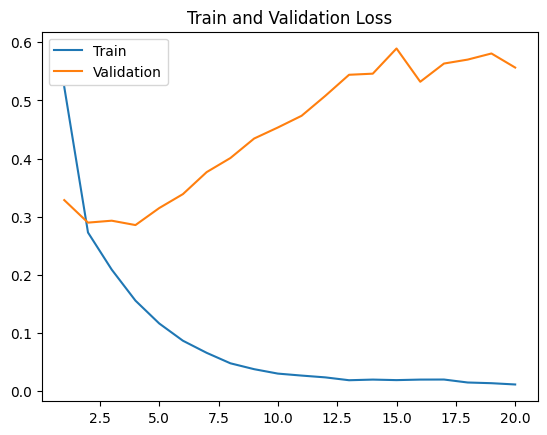

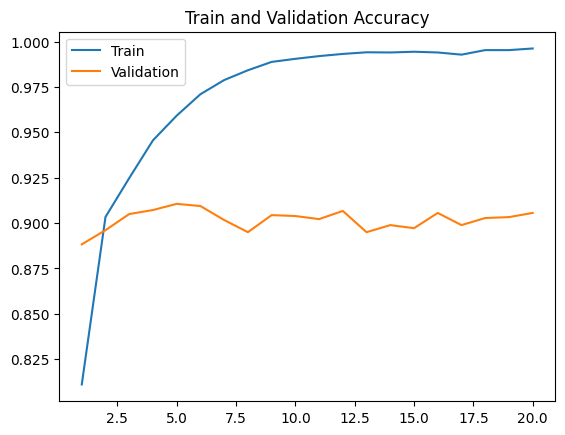

In [18]:
import matplotlib.pyplot as plt
num_epochs = 20

tr_loss = [0] * num_epochs
tr_acc = [0] * num_epochs
val_loss = [0] * num_epochs
val_acc = [0] * num_epochs
epoch = [0] * num_epochs

i = 0
epoch[i] = i + 1
tr_loss[i] = 0.5230
tr_acc[i] = 0.8111
val_loss[i] = 0.3286
val_acc[i] = 0.8883
i += 1

epoch[i] = i + 1
tr_loss[i] = 0.2729
tr_acc[i] = 0.9034
val_loss[i] = 0.2899
val_acc[i] = 0.8961
i += 1

epoch[i] = i + 1
tr_loss[i] = 0.2091
tr_acc[i] = 0.9248
val_loss[i] = 0.2932
val_acc[i] = 0.9050
i += 1

epoch[i] = i + 1
tr_loss[i] = 0.1558
tr_acc[i] = 0.9456
val_loss[i] = 0.2857
val_acc[i] = 0.9072
i += 1

epoch[i] = i + 1
tr_loss[i] = 0.1166
tr_acc[i] = 0.9592
val_loss[i] = 0.3149
val_acc[i] = 0.9106
i += 1

epoch[i] = i + 1
tr_loss[i] = 0.0869
tr_acc[i] = 0.9710
val_loss[i] = 0.3389
val_acc[i] = 0.9094
i += 1

epoch[i] = i + 1
tr_loss[i] = 0.0661
tr_acc[i] = 0.9788
val_loss[i] = 0.3767
val_acc[i] = 0.9017
i += 1

epoch[i] = i + 1
tr_loss[i] = 0.0481
tr_acc[i] = 0.9842
val_loss[i] = 0.4009
val_acc[i] = 0.8950
i += 1

epoch[i] = i + 1
tr_loss[i] = 0.0380
tr_acc[i] = 0.9888
val_loss[i] = 0.4344
val_acc[i] = 0.9044
i += 1
epoch[i] = i + 1
tr_loss[i] = 0.0304
tr_acc[i] = 0.9905
val_loss[i] = 0.4534
val_acc[i] = 0.9039
i += 1

epoch[i] = i + 1
tr_loss[i] = 0.0270
tr_acc[i] = 0.9920
val_loss[i] = 0.4735
val_acc[i] = 0.9022
i += 1

epoch[i] = i + 1
tr_loss[i] = 0.0239
tr_acc[i] = 0.9932
val_loss[i] = 0.5078
val_acc[i] = 0.9067
i += 1

epoch[i] = i + 1
tr_loss[i] = 0.0190
tr_acc[i] = 0.9941
val_loss[i] = 0.5440
val_acc[i] = 0.8950
i += 1

epoch[i] = i + 1
tr_loss[i] = 0.0201
tr_acc[i] = 0.9940
val_loss[i] = 0.5459
val_acc[i] = 0.8989
i += 1

epoch[i] = i + 1
tr_loss[i] = 0.0192
tr_acc[i] = 0.9944
val_loss[i] = 0.5892
val_acc[i] = 0.8972
i += 1

epoch[i] = i + 1
tr_loss[i] = 0.0201
tr_acc[i] = 0.9940
val_loss[i] = 0.5320
val_acc[i] = 0.9056
i += 1

epoch[i] = i + 1
tr_loss[i] = 0.0202
tr_acc[i] = 0.9928
val_loss[i] = 0.5633
val_acc[i] = 0.8989
i += 1

epoch[i] = i + 1
tr_loss[i] = 0.0151
tr_acc[i] = 0.9953
val_loss[i] = 0.5701
val_acc[i] = 0.9028
i += 1

epoch[i] = i + 1
tr_loss[i] = 0.0139
tr_acc[i] = 0.9953
val_loss[i] = 0.5806
val_acc[i] = 0.9033
i += 1

epoch[i] = i + 1
tr_loss[i] = 0.0117
tr_acc[i] = 0.9962
val_loss[i] = 0.5564
val_acc[i] = 0.9056
i += 1

plt.plot(epoch, tr_loss, label = "Train")
plt.plot(epoch, val_loss, label = "Validation")
plt.title("Train and Validation Loss")
plt.legend()
plt.figure()

plt.plot(epoch, tr_acc, label = "Train")
plt.plot(epoch, val_acc, label = "Validation")
plt.title("Train and Validation Accuracy")
plt.legend()
plt.show()

# Evaluate the Best Model: Classification Report, Confusion Matrix, Accuracy, and F1 Score

/tmp/ipykernel_56024/4226895480.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_multimodal_model.pth"))


Processed 10 batches, elapsed time: 7.89 seconds
Processed 20 batches, elapsed time: 15.78 seconds
Processed 30 batches, elapsed time: 23.79 seconds
Processed 40 batches, elapsed time: 32.03 seconds
Processed 50 batches, elapsed time: 40.21 seconds
Test Accuracy: 0.8319
Test F1 Score: 0.8295
Classification Report:
               precision    recall  f1-score   support

       Black       0.76      0.66      0.71       695
        Blue       0.81      0.88      0.84      1086
       Green       0.90      0.94      0.92       799
         TTR       0.84      0.81      0.83       852

    accuracy                           0.83      3432
   macro avg       0.83      0.82      0.82      3432
weighted avg       0.83      0.83      0.83      3432



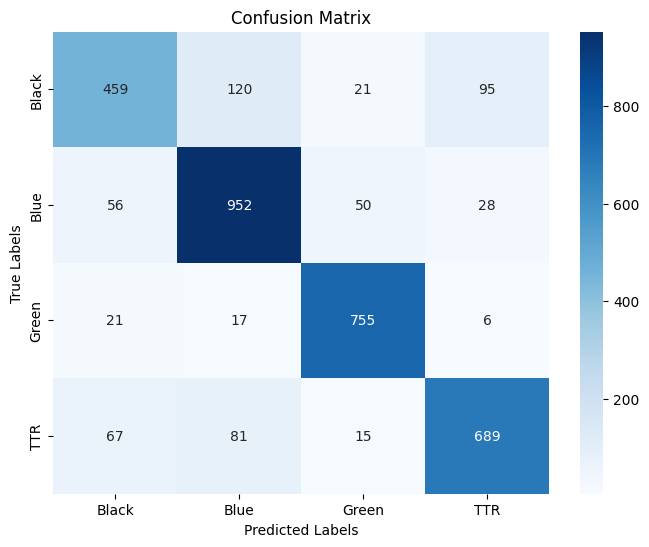

In [28]:
#############################################
# Evaluate 
#############################################

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    batch_count = 0
    start_time = time.time()
    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            texts = batch['text']
            labels = batch['label'].to(device)
            outputs = model(images, texts)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            batch_count += 1
            if batch_count % 10 == 0:
                elapsed = time.time() - start_time
                print(f"Processed {batch_count} batches, elapsed time: {elapsed:.2f} seconds")
    return np.array(all_labels), np.array(all_preds)

# Load the best model
model.load_state_dict(torch.load("best_multimodal_model.pth"))
model.eval()

# Evaluate on the test set
true_labels, pred_labels = evaluate_model(model, dataloaders['test'], device)

accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels, average='weighted')
print("Test Accuracy: {:.4f}".format(accuracy))
print("Test F1 Score: {:.4f}".format(f1))
print("Classification Report:\n", classification_report(true_labels, pred_labels, target_names=dataset_train.classes))

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=dataset_train.classes, yticklabels=dataset_train.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.savefig("confMat.png")
plt.show()


# Visualization

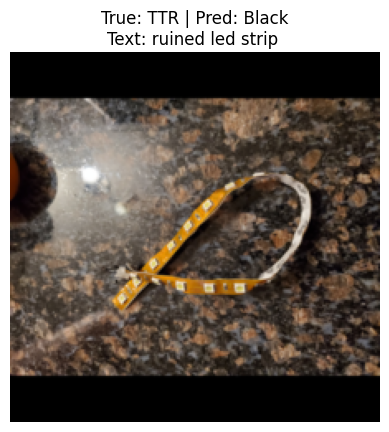

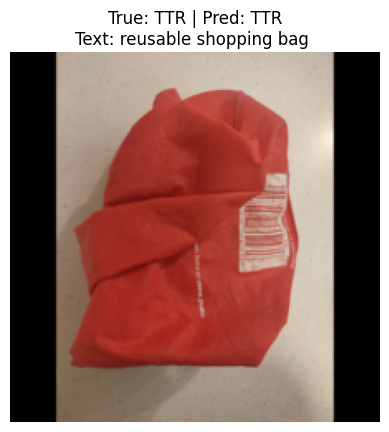

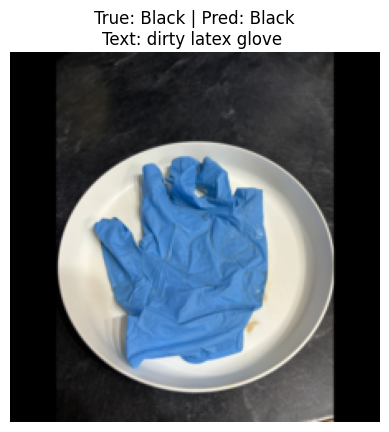

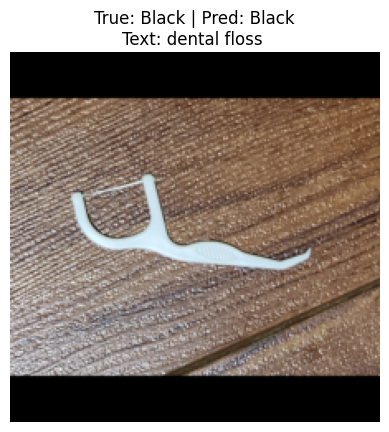

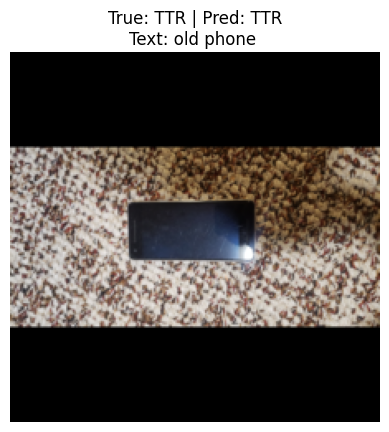

In [19]:
def imshow(inp, title=None):
    """Display a tensor as an image (unnormalizing it first)."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Randomly select a few test samples to display
num_samples = 5
indices = random.sample(range(len(dataset_test)), num_samples)

counter = 1
for idx in indices:
    sample = dataset_test[idx]
    image = sample["image"]
    text = sample["text"]
    label = sample["label"]
    # Prepare image for model (add batch dimension)
    input_image = image.unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_image, [text])
        _, preds = torch.max(outputs, 1)
    pred_class = dataset_train.classes[preds.item()]
    true_class = dataset_train.classes[label]
    plt.figure()
    imshow(image, title=f"True: {true_class} | Pred: {pred_class}\nText: {text}")
    plt.savefig("test_"+str(counter)+".png")
    counter += 1
    plt.show()
    